In [ ]:
! pip install transformers
! pip install datasets

In [ ]:
import torch
from torch import nn
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, WhisperModel
from datasets import load_dataset
from torchaudio import transforms
from tqdm.notebook import tqdm
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vectors = []
labels = []
i = 0
for sample in dataset:
  transform = transforms.Resample(sample['audio']['sampling_rate'], 16000)
  inputs = feature_extractor(sample['audio']['array'], sampling_rate=16000, return_tensors="pt")
  input_features = inputs.input_features.to(device)
  decoder_input_ids = (torch.tensor([[1, 1]]) * model.config.decoder_start_token_id).to(device)
  last_hidden_state = model(input_features, decoder_input_ids=decoder_input_ids).last_hidden_state
  vectors.append(last_hidden_state.detach())
  labels.append(sample['label'])
  i+=1
  if i==10:
    pass

In [ ]:
X = torch.concat(vectors).reshape(len(vectors),vectors[0].shape[1]*vectors[0].shape[2]).cpu()

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

In [ ]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=labels)

In [ ]:
t = WhisperModel.from_pretrained("openai/whisper-base")

In [ ]:
class WhisperCl(torch.nn.Module):
  def __init__(self):
    super(WhisperCl, self).__init__()

    self.encoder = WhisperModel.from_pretrained("openai/whisper-base")
    for param in self.encoder.parameters():
      param.requires_grad = False

    self.flat = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(1024, 512)
    self.relu1 = torch.nn.ReLU()
    self.drp1 = nn.Dropout(p=0.1)

    self.fc2 = torch.nn.Linear(512, 128)
    self.relu2 = torch.nn.ReLU()
    self.drp2 = nn.Dropout(p=0.1)

    self.fc3 = torch.nn.Linear(128, 16)
    self.relu3 = torch.nn.ReLU()

    self.fc4 = torch.nn.Linear(16, 1)

  def forward(self, X: torch.Tensor, decoder_input_ids: torch.Tensor):
    out = self.encoder(X, decoder_input_ids=decoder_input_ids).last_hidden_state

    out = self.flat(out)

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.drp1(out)

    out = self.fc2(out)
    out = self.relu2(out)
    out = self.drp2(out)

    out = self.fc3(out)
    out = self.relu3(out)

    out = self.fc4(out)
    return out

In [ ]:
class GetXY(Dataset):
  def __init__(self, dataset: Dataset, shuffle: bool=True):
    super(GetXY, self).__init__()
    self.dataset = dataset
    self.feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
    self.model = WhisperModel.from_pretrained("openai/whisper-base")
    self.shuffle = shuffle
    self.idx_map = list(range(len(dataset)))
    random.seed(41)
    random.shuffle(self.idx_map)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx: int):
    if self.shuffle:
      idx = self.idx_map[idx]
    sample = self.dataset[idx]
    transform = transforms.Resample(sample['audio']['sampling_rate'], 16000)
    data = transform(sample['audio']['array'])
    inputs = self.feature_extractor(data, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features
    decoder_input_ids = (torch.tensor([[1, 1]]) * self.model.config.decoder_start_token_id)
    return input_features.squeeze(), decoder_input_ids.squeeze(), torch.tensor([sample['label']], dtype=torch.float32)

In [ ]:
train_data = load_dataset('TeamSODA/cl-signal_processing_attacks_large', split='train')

train_loader = GetXY(train_data)

generator = torch.Generator().manual_seed(42)
train_loader, val_loader, test_loader = torch.utils.data.random_split(train_loader, [int(len(train_loader)*0.6), int(len(train_loader)*0.2), int(len(train_loader)*0.2)], generator)

train_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_loader, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=1, shuffle=False)

In [ ]:
model = WhisperCl()
model = model.to(device)

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [ ]:
for X, decoder_input_ids, y in train_loader:
  print(X.shape, decoder_input_ids.shape, y.shape)
  break

torch.Size([120, 80, 3000]) torch.Size([120, 2]) torch.Size([120, 1])


In [ ]:
epochs = 20					############################################################need to change###################################################
losses = []
accuracy = []
model.train()
for epoch in tqdm(range(epochs), desc="epoch"):
  print("epoch : ",epoch)
  epoch_loss=0
  epoch_val_loss=0
  model.train()
  for X, decoder_input_ids, y in tqdm(train_loader):
    X = X.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    output = model(X, decoder_input_ids)
    y = y.to(device)

    loss = loss_function(output, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 

    losses.append(loss.item())
    epoch_loss+=loss.item()
  scheduler.step() 

  print("epoch_train_loss : ",epoch_loss/int(len(train_loader)))
  model.eval()
  for X, decoder_input_ids, y in val_loader:
    X = X.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    output = model(X, decoder_input_ids)
    y = y.to(device)

    loss = loss_function(output, y)
    epoch_val_loss+=loss.item()
  print("epoch_val_loss : ",epoch_val_loss/int(len(val_loader)))

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch :  0


  0%|          | 0/10800 [00:00<?, ?it/s]

epoch_train_loss :  0.2783711215582189
epoch_val_loss :  0.2159864287260058
epoch :  1


  0%|          | 0/10800 [00:00<?, ?it/s]

epoch_train_loss :  0.23802349290702565
epoch_val_loss :  0.21001827448385169
epoch :  2


  0%|          | 0/10800 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
pred=torch.tensor([])
true=torch.tensor([])
model.eval()
i=0
for X, decoder_input_ids, y in tqdm(test_loader):
  X = X.to(device)
  decoder_input_ids = decoder_input_ids.to(device)
  output = model(X, decoder_input_ids)
  pred = torch.cat([pred, torch.flatten(output).cpu().detach()])
  true = torch.cat([true, torch.flatten(y).cpu().detach()])
  i+=1
  if i==10000:#10000
    break

  0%|          | 0/3600 [00:00<?, ?it/s]

In [ ]:
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

from plotnine import *
import plotnine

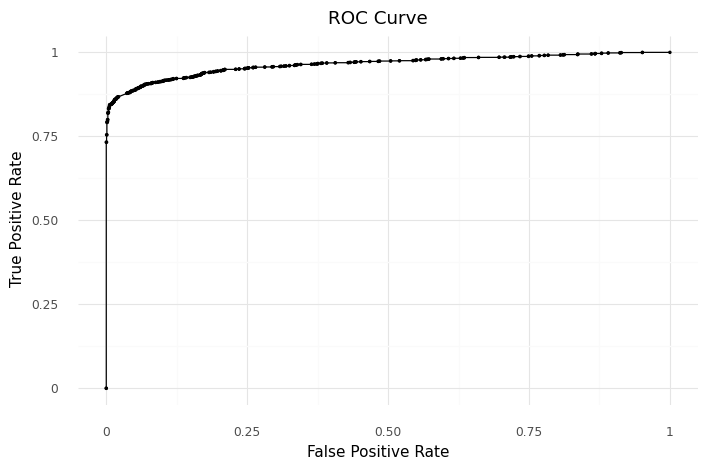

<ggplot: (8755634506188)>

In [ ]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(true, pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

In [ ]:
roc_auc_score(true, pred)

0.964451383409946

Best Threshold: -0.07460000365972519 with G-Mean: 0.9219
FPR: 0.0208, TPR: 0.868


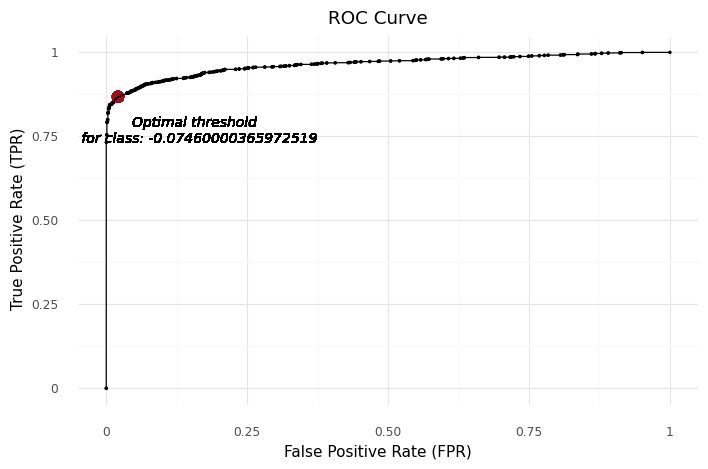

<ggplot: (8754622077442)>

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

In [ ]:
pred_label=torch.tensor([])
true_label=torch.tensor([])
model.eval()
i=0
for X, decoder_input_ids, y in tqdm(test_loader):
  X = X.to(device)
  decoder_input_ids = decoder_input_ids.to(device)
  output = model(X, decoder_input_ids)
  label = 1 if output>=-0.7193999886512756 else 0

In [ ]:
torch.save(model, "/content/drive/MyDrive/models/WhisperCl.h5")